In [33]:
# 验证测量哈密顿量结果等于测量每个子哈密顿量结果的和

In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import qchem

import numpy as np
import qiskit
from qiskit import QuantumCircuit, execute, Aer

In [2]:
from qiskit.quantum_info import DensityMatrix, Statevector

def getDensityMatrix(circuit):
    return DensityMatrix(circuit).data

def getStatevector(circuit):
    """
        从qiskit的QuantumCircuit实例中获取最终的状态向量
        
    """
    return Statevector(circuit).data

In [3]:
from functools import reduce

# eg. Dag(|a>) = <a|
Dag = lambda matrix: matrix.conj().T
# eg. Kron(I, X, Y) = I ⊗ X ⊗ Y，计算张量用
Kron = lambda *matrices: reduce(np.kron, matrices)

## 1. Building the electronic Hamiltonian

In [4]:
# https://pennylane.ai/qml/demos/tutorial_vqe.html

In [5]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

### 1.1 using qml

In [6]:
# 基于JW变换构建的H2哈密顿量
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is    (-0.24274501260941383) [Z2]
+ (-0.24274501260941383) [Z3]
+ (-0.042072551947440084) [I0]
+ (0.1777135822909176) [Z0]
+ (0.1777135822909176) [Z1]
+ (0.12293330449299354) [Z0 Z2]
+ (0.12293330449299354) [Z1 Z3]
+ (0.1676833885560135) [Z0 Z3]
+ (0.1676833885560135) [Z1 Z2]
+ (0.17059759276836806) [Z0 Z1]
+ (0.17627661394181787) [Z2 Z3]
+ (-0.04475008406301996) [Y0 Y1 X2 X3]
+ (-0.04475008406301996) [X0 X1 Y2 Y3]
+ (0.04475008406301996) [Y0 X1 X2 Y3]
+ (0.04475008406301996) [X0 Y1 Y2 X3]


In [7]:
# Hamiltonian.terms() 获取该哈密顿量中的每个组成成分
# 
# 例如第5项：PauliY(wires=[0]) @ PauliX(wires=[1]) @ PauliX(wires=[2]) @ PauliY(wires=[3])
# 对应系数是 0.04475008
# 对应一个哈密顿量的分量（组成成分）为：0.04475008 * Y ⊗ X ⊗ X ⊗ Y，以此类推
# 
H.terms()

(tensor([-0.04207255,  0.17771358,  0.17771358,  0.17059759,  0.04475008,
         -0.04475008, -0.04475008,  0.04475008, -0.24274501,  0.1229333 ,
         -0.24274501,  0.16768339,  0.16768339,  0.1229333 ,  0.17627661], requires_grad=False),
 [Identity(wires=[0]),
  PauliZ(wires=[0]),
  PauliZ(wires=[1]),
  PauliZ(wires=[0]) @ PauliZ(wires=[1]),
  PauliY(wires=[0]) @ PauliX(wires=[1]) @ PauliX(wires=[2]) @ PauliY(wires=[3]),
  PauliY(wires=[0]) @ PauliY(wires=[1]) @ PauliX(wires=[2]) @ PauliX(wires=[3]),
  PauliX(wires=[0]) @ PauliX(wires=[1]) @ PauliY(wires=[2]) @ PauliY(wires=[3]),
  PauliX(wires=[0]) @ PauliY(wires=[1]) @ PauliY(wires=[2]) @ PauliX(wires=[3]),
  PauliZ(wires=[2]),
  PauliZ(wires=[0]) @ PauliZ(wires=[2]),
  PauliZ(wires=[3]),
  PauliZ(wires=[0]) @ PauliZ(wires=[3]),
  PauliZ(wires=[1]) @ PauliZ(wires=[2]),
  PauliZ(wires=[1]) @ PauliZ(wires=[3]),
  PauliZ(wires=[2]) @ PauliZ(wires=[3])])

### 1.2 Manual build

In [8]:
I = np.eye(2)

# pauli matrixes
X = np.matrix([
    [0, 1], [1, 0]
])
Y = np.matrix([
    [0, -1j], [1j, 0]
])
Z = np.matrix([
    [1, 0], [0, -1]
])

In [9]:
# 基于上述分解结果，手动构建初始的Hamilton量
# Kron(Y, X, X, Y) 即计算 Y ⊗ X ⊗ X ⊗ Y
Hami = \
    -0.04207255 * Kron(I, I, I, I) +\
    0.17771358  * Kron(Z, I, I, I) +\
    0.17771358  * Kron(I, Z, I, I) +\
    0.17059759  * Kron(Z, Z, I, I) +\
    0.04475008  * Kron(Y, X, X, Y) +\
    -0.04475008 * Kron(Y, Y, X, X) +\
    -0.04475008 * Kron(X, X, Y, Y) +\
    0.04475008  * Kron(X, Y, Y, X) +\
    -0.24274501 * Kron(I, I, Z, I) +\
    0.1229333   * Kron(Z, I, Z, I) +\
    -0.24274501 * Kron(I, I, I, Z) +\
    0.16768339  * Kron(Z, I, I, Z) +\
    0.16768339  * Kron(I, Z, Z, I) +\
    0.1229333   * Kron(I, Z, I, Z) +\
    0.17627661  * Kron(I, I, Z, Z)

In [10]:
Hami_arr = [
    [-0.04207255 , Kron(I, I, I, I) ],
    [0.17771358  , Kron(Z, I, I, I) ],
    [0.17771358  , Kron(I, Z, I, I) ],
    [0.17059759  , Kron(Z, Z, I, I) ],
    [0.04475008  , Kron(Y, X, X, Y) ],
    [-0.04475008 , Kron(Y, Y, X, X) ],
    [-0.04475008 , Kron(X, X, Y, Y) ],
    [0.04475008  , Kron(X, Y, Y, X) ],
    [-0.24274501 , Kron(I, I, Z, I) ],
    [0.1229333   , Kron(Z, I, Z, I) ],
    [-0.24274501 , Kron(I, I, I, Z) ],
    [0.16768339  , Kron(Z, I, I, Z) ],
    [0.16768339  , Kron(I, Z, Z, I) ],
    [0.1229333   , Kron(I, Z, I, Z) ],
    [0.17627661  , Kron(I, I, Z, Z) ]
]

## 2. Initial state

In [20]:
def reset_endianness_circuit(qubits):
    """
        重置qiskit端序
        
        简单说因为pennylane得到的分解中例如 PauliZ(wires=[0]) @ PauliZ(wires=[1]
        其中wires=[0]并不对应qiskit里的qubit[0]（而是qubit[3]，因为端序的问题）
        所以用这个线路把qiskit的端序重置下
        
        eg.下图的resetCircuit线路，处理前，从下到上才对应wires=[0]，wires=[1]，...
        用SWAP把比特交换下就变成正常的顺序（从上到下对应wires=[0]，wires=[1]，...）
        
    """
    circuit = QuantumCircuit(qubits)
    for i in range(qubits // 2):
        circuit.swap(i, qubits - i - 1)
    circuit.barrier()
    
    return circuit

In [12]:
def get_initial_circuit(electrons, qubits):
    """
        对应 hf = qml.qchem.hf_state(electrons, qubits)
        即获取初始的电子轨道占据情况（hf_state）
        
        eg. electrons=2(电子数)，qubtis=4(比特数，即总轨道数) => [1, 1, 0, 0]（两个电子占据低位轨道）
    """
    circuit = QuantumCircuit(qubits)
    [ circuit.x(i) for i in range(electrons) ]
    circuit.barrier()
    
    return circuit

## 3. Ansatz

### - single excitation

In [14]:
def get_single_excitation_circuit(param, qubits):
    """
        参考上述分解结果，构建通用的单激发Givens Rotation线路
        
        -> https://arxiv.org/pdf/2106.13839.pdf
        
    """
    circuit = QuantumCircuit(4)
    
    circuit.cx(*qubits)
    circuit.cry(param, *list(reversed(qubits)))
    circuit.cx(*qubits)
    circuit.barrier()
    
    return circuit

### - double excitation

In [15]:
def get_double_excitation_circuit(param, qubits):
    """
        参考上述分解结果，构建通用的双激发Givens Rotation线路
        
        -> https://arxiv.org/pdf/2106.13839.pdf
        
    """
    circuit = QuantumCircuit(4)
    
    circuit.cx(qubits[2], qubits[3])
    circuit.cx(qubits[0], qubits[2])
    circuit.h(qubits[3])
    circuit.h(qubits[0])
    circuit.cx(qubits[2], qubits[3])
    circuit.cx(qubits[0], qubits[1])
    circuit.ry(param/8, qubits[1])
    circuit.ry(-param/8, qubits[0])
    circuit.cx(qubits[0], qubits[3])
    circuit.h(qubits[3])
    circuit.cx(qubits[3], qubits[1])
    circuit.ry(param/8, qubits[1])
    circuit.ry(-param/8, qubits[0])
    circuit.cx(qubits[2], qubits[1])
    circuit.cx(qubits[2], qubits[0])
    circuit.ry(-param/8, qubits[1])
    circuit.ry(param/8, qubits[0])
    circuit.cx(qubits[3], qubits[1])
    circuit.h(qubits[3])
    circuit.cx(qubits[0], qubits[3])
    circuit.ry(-param/8, qubits[1])
    circuit.ry(param/8, qubits[0])
    circuit.cx(qubits[0], qubits[1])
    circuit.cx(qubits[2], qubits[0])
    circuit.h(qubits[0])
    circuit.h(qubits[3])
    circuit.cx(qubits[0], qubits[2])
    circuit.cx(qubits[2], qubits[3])
    circuit.barrier()
    
    return circuit

### - full Givens rotation circuit

In [16]:
def get_givens_circuit(params):
    """
        组装完整的基于Givens Rotation的拟设线路，包含所有的单激发与双激发
        
        注：https://pennylane.ai/qml/demos/tutorial_vqe.html 的例子求解H2分子时候，
        基于某种化学假设，只考虑了双激发（不清楚具体理由），这边实现的是同时考虑所有单激发与双激发
        结果也可以正常求得
        
        单激发与双激发的类型这里暂时写死，有待未来完善
        
    """
    # 1100 -> 0110 1001 0011
    singles = [[0, 2], [1, 3]]
    doubles = [[0, 1, 2, 3]]
    
    circuit = QuantumCircuit(4)
    
    idx = 0
    
    for single in singles:
        circuit = circuit.compose(get_single_excitation_circuit(params[idx], single))
        idx += 1
        
    for double in doubles:
        circuit = circuit.compose(get_double_excitation_circuit(params[idx], double))
        idx += 1
        
    return circuit

## 4. VQE full circuits

In [21]:
resetCircuit = reset_endianness_circuit(4)

In [27]:
initCircuit = get_initial_circuit(2, 4)

In [28]:
def get_full_circuit(ansatz, params):
    """
        搭建完整线路
        
        :param ansatz: 构建拟设线路的函数
        :param params: 拟设函数的参数，即ansatz(params)返回拟设线路
        
        1. resetCircuit 在整个线路前后用来调整端序
        2. initCircuit 对应初始 hf_state，eg. [1, 1, 0, 0]
        3. ansatz(params) 对应拟设（带参数）主体
        
    """
    return resetCircuit.compose(
        initCircuit.compose(
            ansatz(params).compose(resetCircuit)
        )
    )

In [29]:
def expval(Hami, circuit):
    """
        基于哈密顿量与拟设计算期望值
        
        1. 初始态是hf_state，eg. [1, 1, 0, 0] 记为 |φ>,
        2. 通过拟设（例如一组Givens Rotation），态演化为 U(θ)|φ>, U(θ)对应某个拟设，记U(θ)|φ> = |Ψ(θ)>
        3. 计算和哈密顿量间的期望：<Ψ(θ)| H |Ψ(θ)>
        
    """
    state = getStatevector(circuit) # 获取线路终态
    size = len(state)
    
    right = state.reshape(size, 1)
    left = Dag(right)
    
    # 计算 <Ψ(θ)| H |Ψ(θ)>
    return (left @ Hami @ right)[0, 0].real

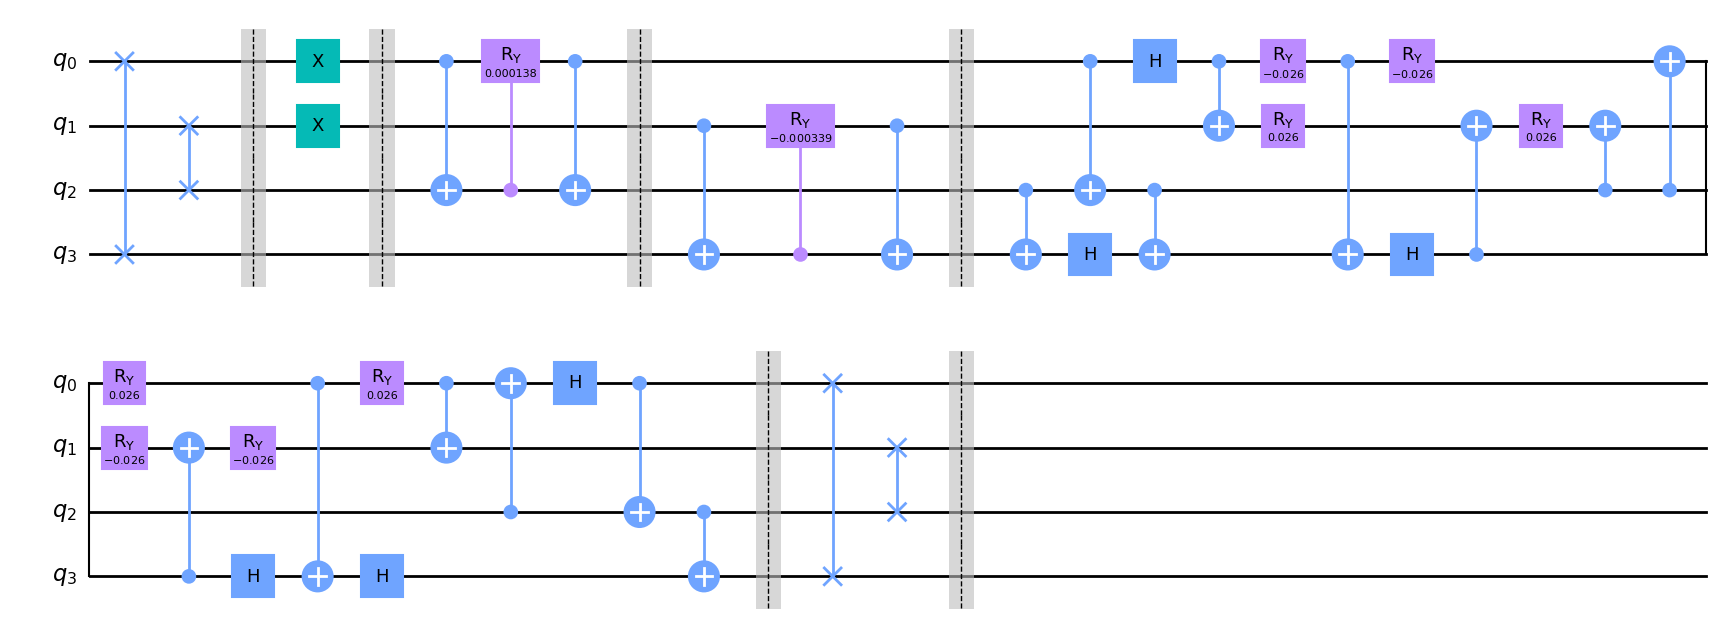

In [30]:
# 完整VQE（基于Givens Rotation）线路
circuit = get_full_circuit(get_givens_circuit, [1.37834905e-04,  -3.38682040e-04,  2.08187026e-01])
circuit.draw(output='mpl')

In [31]:
print('expval result: ', expval(Hami, circuit))

expval result:  -1.1361880888446667


In [32]:
exp = 0.0
for [ coef, sub_Hami ] in Hami_arr:
    exp += coef * expval(sub_Hami, circuit)
exp

-1.1361880888446665